In [1]:
suppressMessages(library(ggplot2))
suppressMessages(library(ggView))
suppressMessages(library(MAGeCKFlute))
suppressMessages(library(rcompanion))
options(stringsAsFactors = FALSE)

In [2]:
Degradability = readRDS("data/Donovan_Degradability.rds")
Degradability = Degradability[Degradability$IsKinase, ]
Lysines = read.table("data/Lysine_E2_Accessibility.txt", sep = "\t", header = TRUE)

In [3]:
engaged  = readRDS("data/All_engaged.rds")
Lowly = c(engaged, Degradability$Gene[Degradability$MinLFC< -log2(1.25)])
Lowly = intersect(Lowly, Degradability$Gene[Degradability$DetectFreq>151*0.1])
Lowly = intersect(Lowly, Degradability$Gene[Degradability$UniqDegradeFreq<1])
Highly = Degradability$Gene[Degradability$UniqDegradeFreq>1]
length(Lowly)
length(Highly)

[1] 139

[1] 114

In [4]:
TotalUbs = as.data.frame(table(Lysines$GeneID[grepl("ub", Lysines$MOD_RSD)]))
TotalLys = as.data.frame(table(Lysines$GeneID[Lysines$MOD_RSD=="K"]))
Summary = merge(TotalLys, TotalUbs, by = "Var1", all = TRUE)
colnames(Summary) = c("Gene", "TotalLys", "TotalUB")
for(filter in seq(0,1,0.1)){
    idx = Lysines$E2_accessible_orientation>=filter
    AccUbs = as.data.frame(table(Lysines$GeneID[idx & grepl("ub", Lysines$MOD_RSD)]))
    AccLys = as.data.frame(table(Lysines$GeneID[idx & Lysines$MOD_RSD=="K"]))
    colnames(AccLys) = c("Gene", paste0("Lysine_", filter))
    colnames(AccUbs) = c("Gene", paste0("UbSite_", filter))
    Summary = merge(Summary, AccLys, by = "Gene", all = TRUE)
    Summary = merge(Summary, AccUbs, by = "Gene", all = TRUE)
    Summary[is.na(Summary)] = 0
}
Summary = Summary[Summary$Lysine_0>0, ]
rownames(Summary) = Summary$Gene
head(Summary)

,Gene,TotalLys,TotalUB,Lysine_0,UbSite_0,Lysine_0.1,UbSite_0.1,Lysine_0.2,UbSite_0.2,Lysine_0.3,⋯,Lysine_0.6,UbSite_0.6,Lysine_0.7,UbSite_0.7,Lysine_0.8,UbSite_0.8,Lysine_0.9,UbSite_0.9,Lysine_1,UbSite_1
,<fct>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AAK1,AAK1,16,1,16,1,13,1,13,1,8,⋯,7,0,6,0,3,0,0,0,0,0
ABL1,ABL1,17,0,17,0,14,0,11,0,10,⋯,1,0,0,0,0,0,0,0,0,0
ABL2,ABL2,17,0,17,0,16,0,9,0,6,⋯,4,0,3,0,0,0,0,0,0,0
ACVR1,ACVR1,14,0,14,0,10,0,9,0,8,⋯,4,0,3,0,1,0,0,0,0,0
ACVR2A,ACVR2A,17,0,17,0,15,0,11,0,8,⋯,4,0,1,0,0,0,0,0,0,0
ACVR2B,ACVR2B,15,1,15,1,13,1,10,0,6,⋯,3,0,1,0,0,0,0,0,0,0


In [5]:
tmpdat = Summary[Summary$Gene%in%c(Highly, Lowly), ]
tmpdat$Group = "low"
tmpdat$Group[tmpdat$Gene%in%Highly] = "high"
table(tmpdat$Group)

LysineZ = apply(tmpdat[, grepl("UbSite|Lysine", colnames(tmpdat))], 2, function(x){
    tmp = suppressWarnings(wilcoxonZ(x[tmpdat$Group=="high"], x[tmpdat$Group=="low"]))
})


high  low 
  55   53 

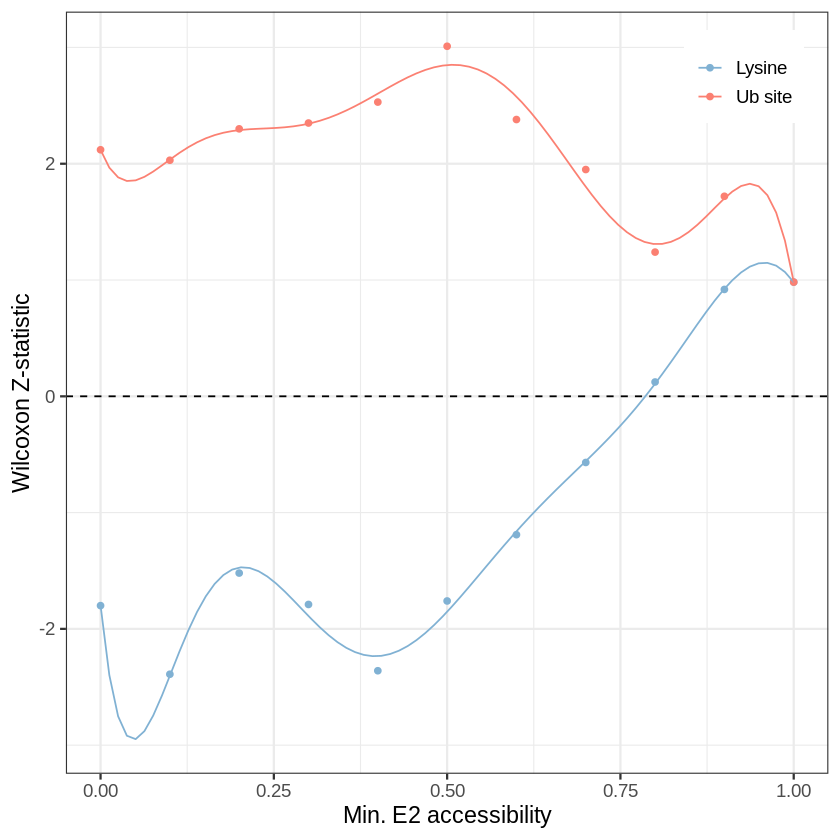

In [6]:
gg = data.frame(Term = names(LysineZ), Type = gsub("_.*", "", names(LysineZ)), 
                Accessibility = gsub(".*_", "", names(LysineZ)), 
                Zscore = LysineZ, stringsAsFactors = FALSE)
gg$Accessibility = as.numeric(gg$Accessibility)
p = ggplot(gg, aes(Accessibility, Zscore, color = Type))
p = p + geom_point()
p = p + stat_smooth(method = "lm", formula = y ~ poly(x, 8), size = 0.5, se = FALSE)
p = p + scale_color_manual(values = c("#80b1d3", "#fb8072"), labels = c("Lysine", "Ub site"))
p = p + theme_bw(base_size = 14)
p = p + geom_hline(yintercept = 0, linetype = "dashed")
p = p + labs(x = "Min. E2 accessibility", y = "Wilcoxon Z-statistic", color = NULL)
p = p + theme(legend.position = c(1,1), legend.justification = c(1.2,1.2))
p

In [7]:
tmpdat = Summary[Summary$Gene%in%c(Highly, Lowly), ]
tmpdat$Group = "low"
tmpdat$Group[tmpdat$Gene%in%Highly] = "high"
table(tmpdat$Group)


high  low 
  55   53 

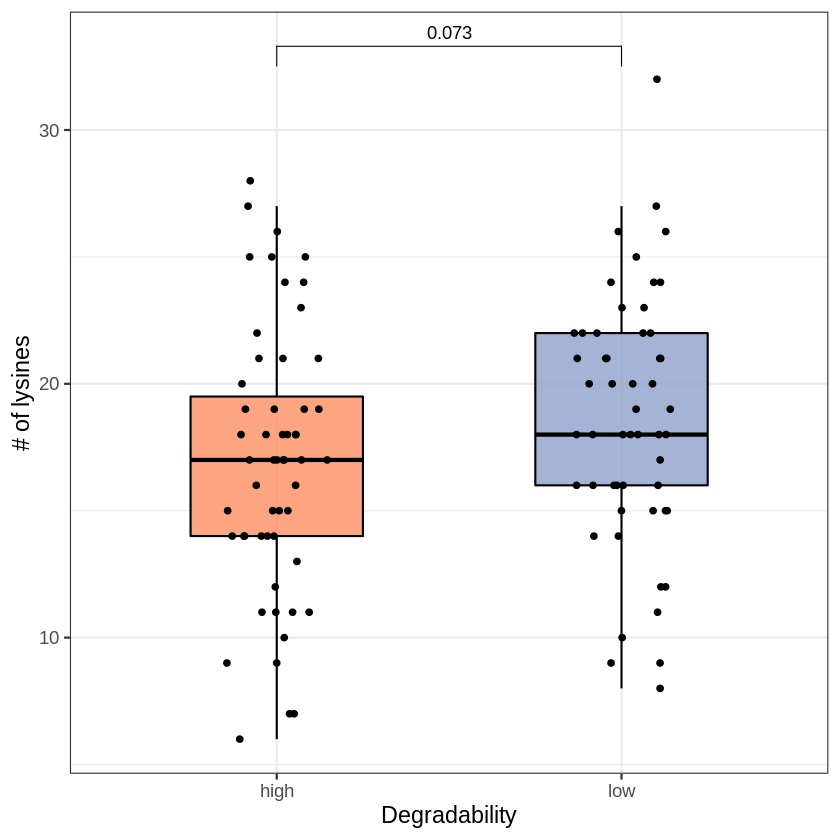

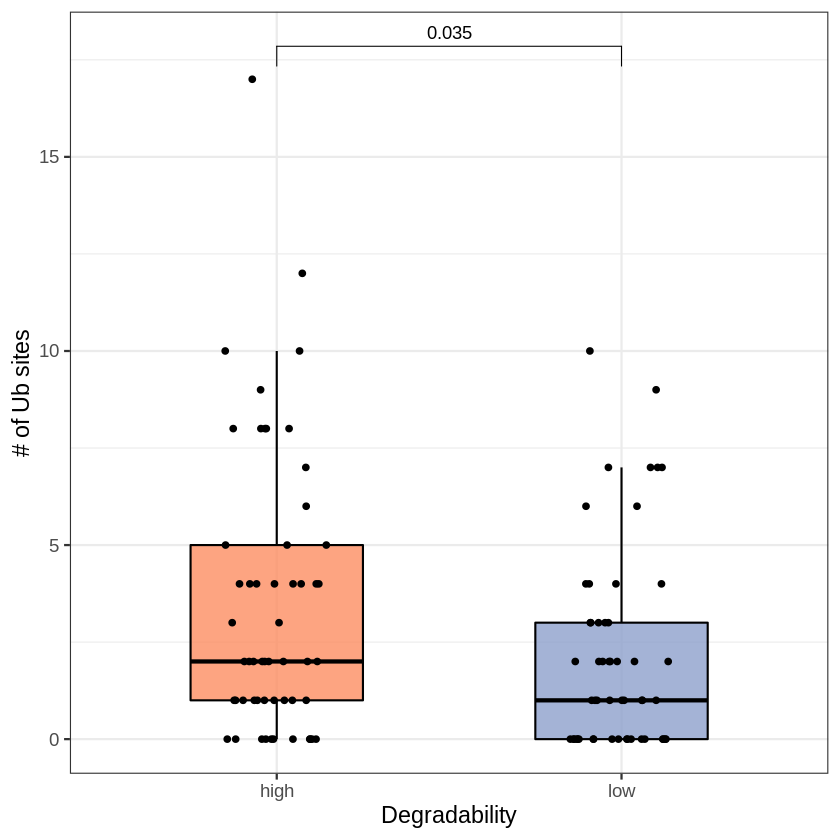

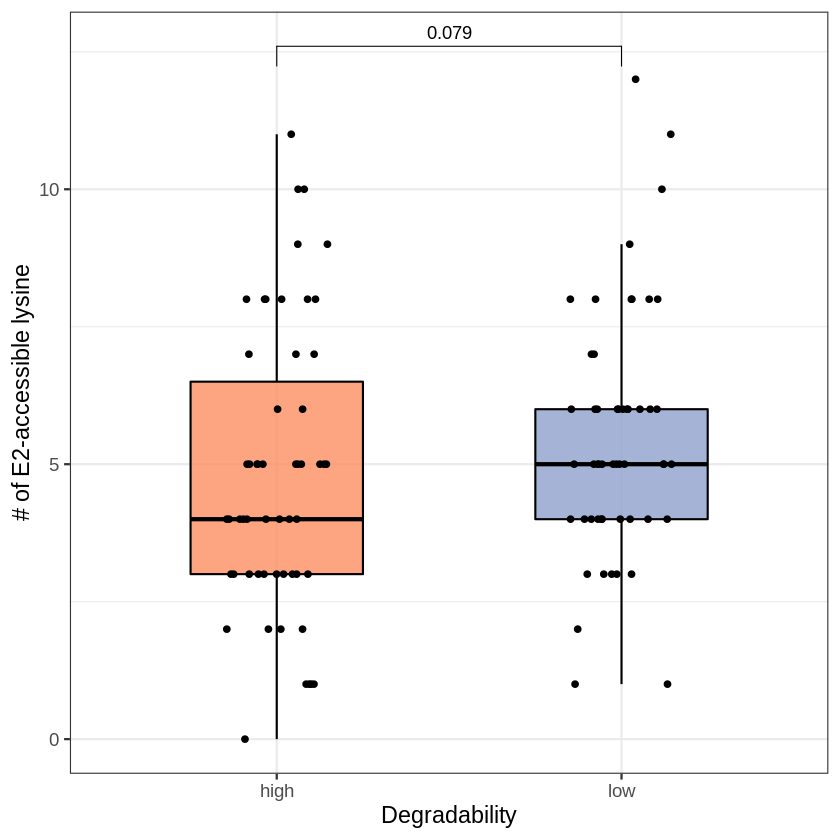

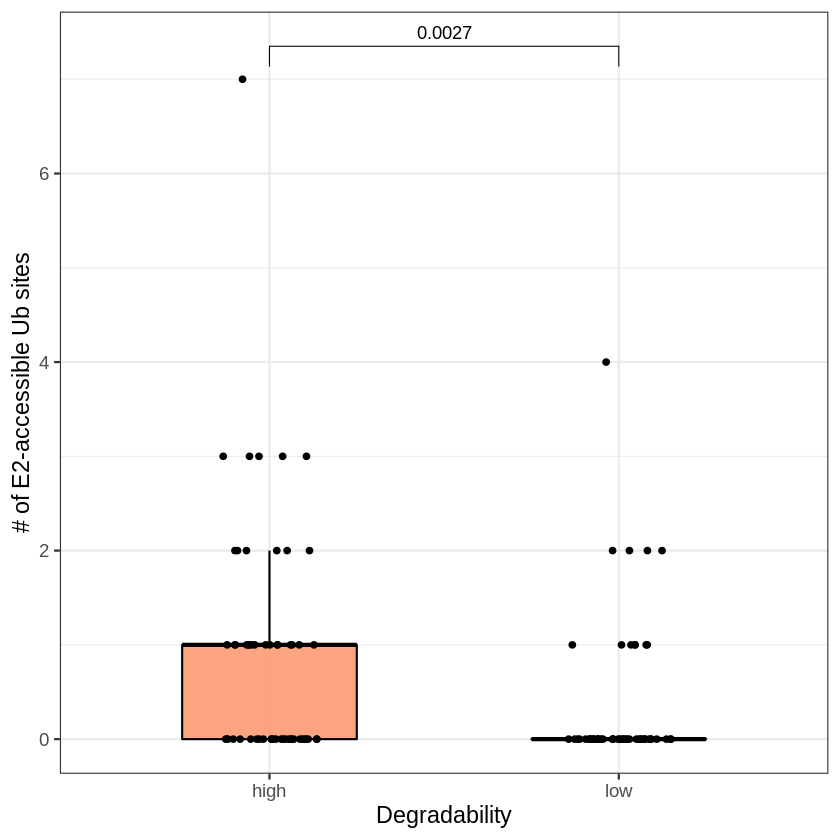

In [8]:
p = BoxView(tmpdat, "Group", "TotalLys", xlab = "Degradability", ylab = "# of lysines", 
            alpha = 0.8, size = 0.6, fill = "Group", comparisons = list(c("low","high")), p.label = "p.format")
p = p + geom_jitter(width = 0.15, height = 0)
p = p + scale_fill_manual(values = c("#fc8d62", "#8da0cb"))
p

p = BoxView(tmpdat, "Group", "TotalUB", xlab = "Degradability", ylab = "# of Ub sites", 
            alpha = 0.8, size = 0.6, fill = "Group", comparisons = list(c("low","high")), p.label = "p.format")
p = p + geom_jitter(width = 0.15, height = 0)
p = p + scale_fill_manual(values = c("#fc8d62", "#8da0cb"))
p

p = BoxView(tmpdat, "Group", "Lysine_0.5", xlab = "Degradability", ylab = "# of E2-accessible lysine", 
            alpha = 0.8, size = 0.6, fill = "Group", comparisons = list(c("low","high")), p.label = "p.format")
p = p + geom_jitter(width = 0.15, height = 0)
p = p + scale_fill_manual(values = c("#fc8d62", "#8da0cb"))
p

p = BoxView(tmpdat, "Group", "UbSite_0.5", xlab = "Degradability", ylab = "# of E2-accessible Ub sites", 
            alpha = 0.8, size = 0.6, fill = "Group", comparisons = list(c("low","high")), p.label = "p.format")
p = p + geom_jitter(width = 0.15, height = 0)
p = p + scale_fill_manual(values = c("#fc8d62", "#8da0cb"))
p

In [9]:
AccUBs_BG = sapply(unique(Lysines$GeneID), function(g){
    K_idx = which(Lysines$GeneID==g & Lysines$MOD_RSD=="K")
    nUB = sum(Lysines$GeneID==g & grepl("ub$", Lysines$MOD_RSD))
    sapply(1:10000, function(i){
        ridx = sample(K_idx, nUB)
        sum(Lysines$E2_accessible_orientation[ridx]>=0.5)
    })
})
AccUBs_BG = AccUBs_BG[, tmpdat$Gene]
Effects = apply(AccUBs_BG, 1, function(x){
    wilcoxonZ(x[tmpdat$Group=="high"], x[tmpdat$Group=="low"])
})

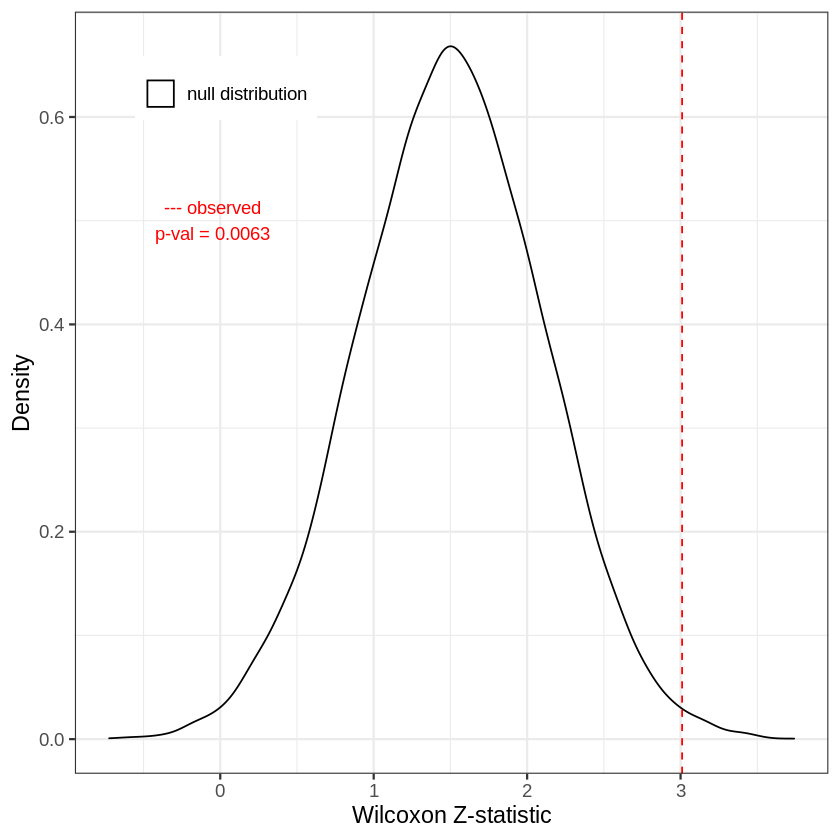

In [10]:
Observed = wilcoxonZ(tmpdat$`UbSite_0.5`[tmpdat$Group=="high"], tmpdat$`UbSite_0.5`[tmpdat$Group=="low"])
gg = data.frame(Effect = Effects)
p = ggplot(gg, aes(x = Effect, color = "null distribution"))
p = p + geom_density(size = 0.5)
p = p + scale_color_manual(values = c("black"))
p = p + geom_vline(xintercept = Observed, color = "red", linetype = "dashed", size = 0.5)
pval = sum(Effects>Observed) / 10000
p = p + annotate("text", x = -0.05, y = 0.5, label = paste0("--- observed\n", "p-val = ", pval), color = "red")
p = p + labs(x = "Wilcoxon Z-statistic", y = "Density", color = NULL)
p = p + theme_bw(base_size = 14)
p = p + theme(legend.position = c(0.2,0.9))
p

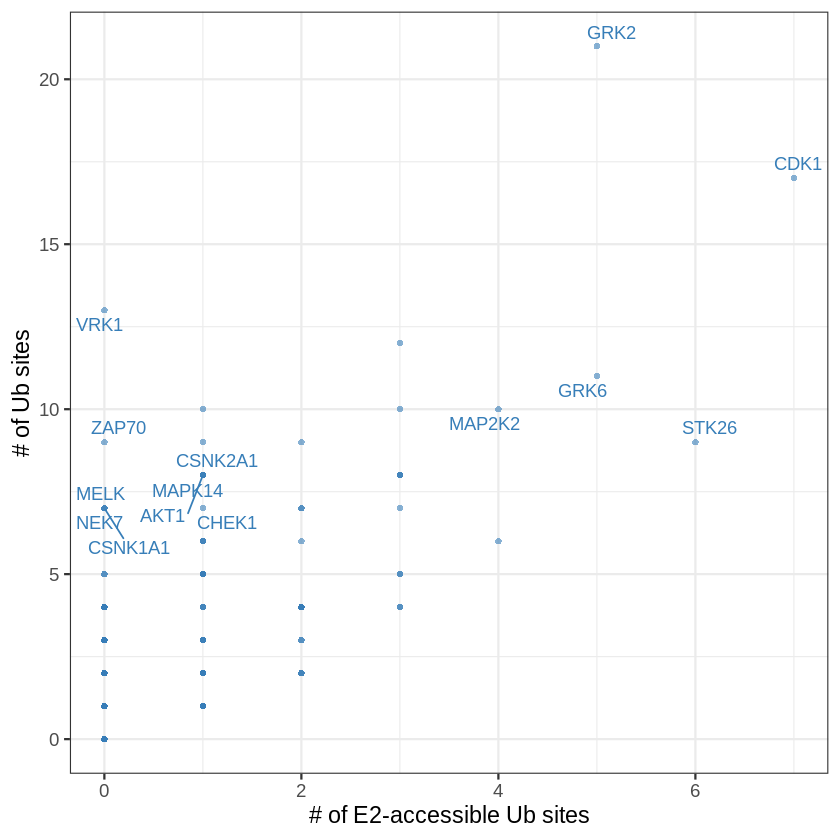

In [11]:
toplabels = Summary$Gene[Summary$TotalUB>6 & Summary$UbSite_0.5<2]
toplabels = intersect(toplabels, Degradability$Gene[Degradability$UniqDegradeFreq<1])
toplabels = c(toplabels, "MAPK14", "AKT1", "CSNK1A1")
p = ScatterView(Summary, "UbSite_0.5", "TotalUB", label = "Gene", color = "#377eb8", toplabels = toplabels,
                size = 1.5, x_cut = 3, y_cut = 3, groups = c("topright"), top = 5, max.overlaps = Inf)
p = p + labs(x = "# of E2-accessible Ub sites", y = "# of Ub sites")
p = p + theme_bw(base_size = 14)
p = p + theme(legend.position = "none")
p

In [12]:
gg = Summary[Summary$TotalUB>1, c("UbSite_0.5", "TotalUB")]
gg = gg[rownames(gg)%in%c(Lowly, Highly), ]
gg = cbind(gg, Degradability[rownames(gg), ])
head(gg)

,UbSite_0.5,TotalUB,Gene,DetectFreq,DegradeFreq,MinLFC,UniqDegradeFreq,CRBNDetectFreq,CRBNDegradeFreq,CRBN_MinLFC,IsKinase
,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
AKT1,1,8,AKT1,151,5,-3.205546,2,66,2,-3.205546,TRUE
AKT2,2,4,AKT2,151,7,-3.155945,3,66,3,-3.155945,TRUE
AURKA,0,3,AURKA,151,56,-3.744629,23,66,23,-3.744629,TRUE
AURKB,3,10,AURKB,151,22,-1.831984,6,66,5,-1.831984,TRUE
BTK,0,4,BTK,10,4,-3.263337,3,8,3,-3.263337,TRUE
CAMKK2,0,4,CAMKK2,151,0,-0.162933,0,66,0,-0.162933,TRUE



 >1 <=1 
 14  38 

,UbSite_0.5,TotalUB,Gene,DetectFreq,DegradeFreq,MinLFC,UniqDegradeFreq,CRBNDetectFreq,CRBNDegradeFreq,CRBN_MinLFC,IsKinase,Group
,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<fct>
AKT1,1,8,AKT1,151,5,-3.205546,2,66,2,-3.205546,TRUE,<=1
AKT2,2,4,AKT2,151,7,-3.155945,3,66,3,-3.155945,TRUE,>1
AURKA,0,3,AURKA,151,56,-3.744629,23,66,23,-3.744629,TRUE,<=1
AURKB,3,10,AURKB,151,22,-1.831984,6,66,5,-1.831984,TRUE,>1
CAMKK2,0,4,CAMKK2,151,0,-0.162933,0,66,0,-0.162933,TRUE,<=1
CDK1,7,17,CDK1,151,10,-1.641245,4,66,4,-1.641245,TRUE,>1


Warning message in wilcox.test.default(c(3, 5, 4, 4, 8, 19, 15, 2, 7, 9, 0, 0, 6, :
“cannot compute exact p-value with ties”


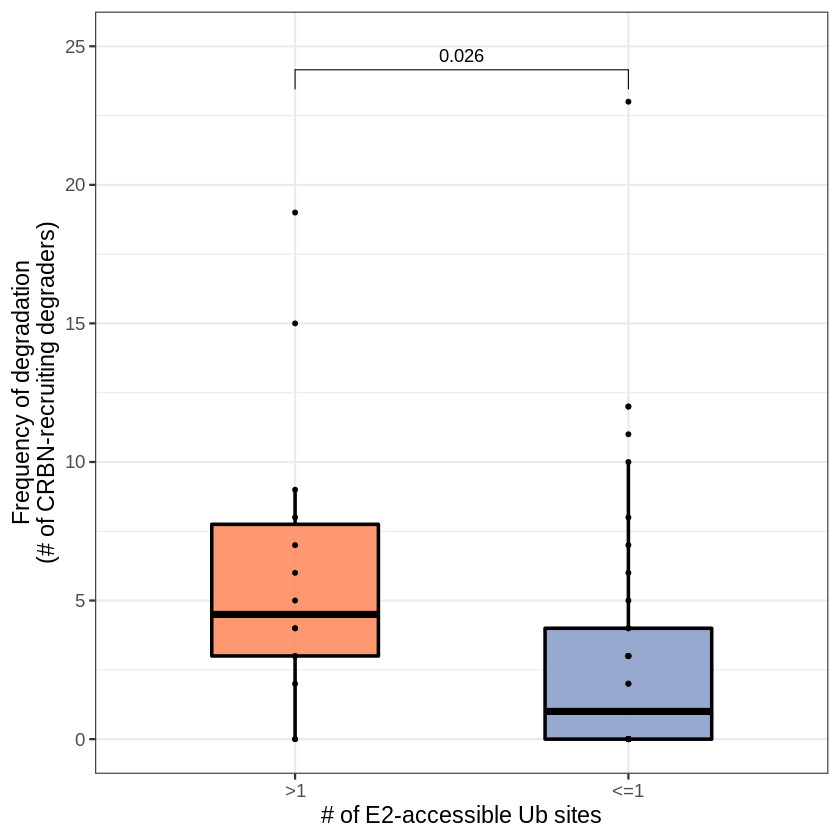

In [13]:
engaged  = readRDS("data/All_engaged.rds")
degraded = Degradability$Gene[Degradability$UniqDegradeFreq>0]
gg = Summary[Summary$TotalUB>1, c("UbSite_0.5", "TotalUB")]
gg = gg[rownames(gg) %in% c(engaged, degraded), ]
gg = cbind(gg, Degradability[rownames(gg), ])
gg$Group = "<=1"
gg$Group[gg$`UbSite_0.5`>1] = ">1"
gg$Group = factor(gg$Group, levels = c(">1", "<=1"))
gg = gg[gg$DetectFreq>20, ]
table(gg$Group)
gg = na.omit(gg)
head(gg)
p = BoxView(gg, "Group", "CRBNDegradeFreq", comparisons = list(c(">1", "<=1")), p.label = "p.value", 
            fill = "Group", alpha = 0.9, xlab = "# of E2-accessible Ub sites", 
            ylab = "Frequency of degradation\n(# of CRBN-recruiting degraders)")
p = p + geom_point(size = 1)
p = p + scale_fill_manual(values = c("#fc8d62", "#8da0cb"))
p = p + ylim(NA, 25)
p